# Data Wrangling
By: Austin

Introduction
This project focused on wrangling data from the WeRateDogs Twitter account using Python, documented in a Jupyter Notebook (wrangle_act.ipynb). This Twitter account rates dogs with humorous commentary. The rating denominator is usually 10, however, the numerators are usually greater than 10. They’re Good Dogs Brent wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for us to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

The goal of this project is to wrangle the WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The challenge lies in the fact that the Twitter archive is great, but it only contains very basic tweet information that comes in JSON format. I needed to gather, asses and clean the Twitter data for a worthy analysis and visualization.

The Data
Enhanced Twitter Archive
The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced.".We manually downloaded this file manually by clicking the following link: twitter_archive_enhanced.csv


## Key Points
Key points to keep in mind when data wrangling for this project:

We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

Fully assessing and cleaning the entire dataset requires exceptional effort so only a subset of its issues (eight (8) quality issues and two (2) tidiness issues at minimum) need to be assessed and cleaned.

Cleaning includes merging individual pieces of data according to the rules of tidy data.

The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.

We do not need to gather the tweets beyond August 1st, 2017. We can, but note that we won't be able to gather the image predictions for these tweets since we don't have access to the algorithm used.

## Project Details
Fully assessing and cleaning the entire dataset would require exceptional effort so only a subset of its issues (eight quality issues and two tidiness issues at minimum) needed to be assessed and cleaned.

## Tasks for this project:

Data wrangling, which consists of:
Gathering data
Assessing data
Cleaning data
Storing, analyzing, and visualizing our wrangled data
Reporting on 1) our data wrangling efforts and 2) our data analyses and visualizations

## Let's Gather

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [4]:
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [5]:
API_KEY = 'nDWUGUpBuWI2INaDKFW03yBu4'
API_SECRET_KEY = 'YVVZm9TBAkXGmBldOForu8C5wFJ0cn75wL2JsJkUOlFHLhwdSN'
ACCESS_TOKEN = '1396235859079307264-AvCxD2KtUyga7GIRjCenKtBRNXRxGU'
ACCESS_TOKEN_SECRET = 'TEAM8u2fbGwR0InGhA2psVkg6J3ZDJMV6H3TuV6VRxkiw'

auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

In [6]:
df_list = []
error_list = []

start = time.time()

# Will add each available tweet json to df_list
for tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit = True,
                               wait_on_rate_limit_notify = True)._json 
        favorites = tweet['favorite_count'] # tweet's favorites
        retweets = tweet['retweet_count'] 
        user_followers = tweet['user']['followers_count'] 
        user_favourites = tweet['user']['favourites_count'] # user's favorites
        date_time = tweet['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id), 'favorites': int(favorites), 'retweets': int(retweets),
                        'user_followers': int(user_followers), 'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
        
    except Exception as e:
        print(str(tweet_id)+ " __ " + str(e))
        error_list.append(tweet_id)
        

end = time.time()
print(end - start)

888202515573088257 __ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 __ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 __ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 __ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 __ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 __ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 __ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 __ [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 __ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 __ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 __ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 __ [{'code': 144, 'message': 'No status found with that ID.'}]
8373662848745717

Rate limit reached. Sleeping for: 724


757597904299253760 __ [{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]
754011816964026368 __ [{'code': 144, 'message': 'No status found with that ID.'}]
680055455951884288 __ [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 730


1913.430600643158


In [7]:
print("The lengh of the result", len(df_list))
print("The lengh of the errors", len(error_list))

The lengh of the result 2330
The lengh of the errors 26


- We reached the limit of Twitter APIs 2 times.

- We got 2330 tweet_id correctly and 26 errors.

- The total time was 1913.43 seconds = about 32 min.

In [8]:
# Create DataFrames 'json' and save it in a file
json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets', 'user_followers',
                                               'user_favourites', 'date_time'])
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [9]:
tweet_data = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
tweet_data

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,34738,7279,9006261,145403,2017-08-01 16:23:56+00:00
1,892177421306343426,30109,5444,9006261,145403,2017-08-01 00:17:27+00:00
2,891815181378084864,22661,3585,9006261,145403,2017-07-31 00:18:03+00:00
3,891689557279858688,38003,7466,9006261,145403,2017-07-30 15:58:51+00:00
4,891327558926688256,36284,8029,9006261,145403,2017-07-29 16:00:24+00:00
...,...,...,...,...,...,...
2325,666049248165822465,92,37,9006278,145403,2015-11-16 00:24:50+00:00
2326,666044226329800704,255,120,9006278,145403,2015-11-16 00:04:52+00:00
2327,666033412701032449,105,38,9006278,145403,2015-11-15 23:21:54+00:00
2328,666029285002620928,117,41,9006278,145403,2015-11-15 23:05:30+00:00


## Gathering Summary
We finished the first step in the data wrangling. We managed to gather data from an existing csv file, downloaded a tsv file and queried Twitter's API using Tweepy. Finally, we imported the data into the Jupyter Notebook.

## Assessing

In [10]:
#Random samples to assess visually
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
295,837471256429613056,NaN,NaN,2017-03-03 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Vincent. He's suave as h*ck. Will be y...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/837471256...,12,10,Vincent,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
376,828046555563323392,NaN,NaN,2017-02-05 01:04:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sailer. He waits on the roof for his o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/828046555...,13,10,Sailer,None,None,None,None
2131,670086499208155136,NaN,NaN,2015-11-27 03:47:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Hi yes this is dog. I can't help with that s-...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/670086499...,10,10,None,None,None,None,None
1439,696894894812565505,NaN,NaN,2016-02-09 03:14:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These two pirates crashed their ship and don't...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/696894894...,9,10,None,None,None,None,None
1079,739238157791694849,NaN,NaN,2016-06-04 23:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739238157...,13,10,None,doggo,None,None,None
732,781524693396357120,NaN,NaN,2016-09-29 16:03:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Idk why this keeps happening. We only rate dog...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781524693...,12,10,None,None,None,None,None
1826,676440007570247681,NaN,NaN,2015-12-14 16:34:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Hope your Monday isn't too awful. Here's two b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676440007...,11,10,None,None,None,None,None
16,888917238123831296,NaN,NaN,2017-07-23 00:22:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jim. He found a fren. Taught him how t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/888917238...,12,10,Jim,None,None,None,None


Quality: Source format is bad and can not be read easily.

Tidiness: Dog stage is unnecessarily in 4 columns (doggo, floofer, pupper, puppo). This is unnecessary. 

In [11]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Quality: 
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be integers/strings instead of float.
- retweeted_status_timestamp, timestamp should be datetime instead of object (string).
- We may want to change these columns types (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id and tweet_id) to string because we don't want any operations on them.

In [12]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
image_predictions.info()
image_predictions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [14]:
image_predictions['jpg_url'].value_counts()

https://pbs.twimg.com/media/Ck2d7tJWUAEPTL3.jpg    2
https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg    2
https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg    2
https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg    2
https://pbs.twimg.com/media/CsGnz64WYAEIDHJ.jpg    2
                                                  ..
https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg    1
https://pbs.twimg.com/media/CcO66OjXEAASXmH.jpg    1
https://pbs.twimg.com/media/C7xzmngWkAAAp9C.jpg    1
https://pbs.twimg.com/media/C8G0_CMWsAAjjAY.jpg    1
https://pbs.twimg.com/media/C4AqLSgVYAEg8nt.jpg    1
Name: jpg_url, Length: 2009, dtype: int64

Quality: 
- There are missing values from images dataset.
- Becuase of retweets, some tweets have 2 different tweet_id.

In [15]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [16]:
twitter_archive[twitter_archive['rating_numerator'] > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


Quality: The numerator and denominator columns have invalid values.

In [17]:
twitter_archive[twitter_archive['name'].apply(len) <= 2 ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,None,None,None,None
446,819015337530290176,NaN,NaN,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He was a very good ...,8.190048e+17,4.196984e+09,2017-01-11 02:15:36 +0000,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
449,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


Quality: There are invalid names (a, an and less than 3 characters).

In [18]:
#Orignal tweets 
twitter_archive[twitter_archive['retweeted_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


Quality: We see that there are retweets and we want to avoid this.

In [19]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2330 non-null   int64 
 1   favorites        2330 non-null   int64 
 2   retweets         2330 non-null   int64 
 3   user_followers   2330 non-null   int64 
 4   user_favourites  2330 non-null   int64 
 5   date_time        2330 non-null   object
dtypes: int64(5), object(1)
memory usage: 109.3+ KB


## Assessing Summary
Quality: 
- In several columns null objects are non-null (None to NaN).
- There are invalid names (a, an and less than 3 characters).- We only want original ratings tweets, not retweets.
- Some tweet_ids have the same jpg_url
- Some tweets have 2 different tweet_id, that are retweets.
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be integers/strings instead of float.
- retweeted_status_timestamp, timestamp should be datetime instead of object (string).
- The numerator and denominator columns have invalid values.
- We might change the type of columns: (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id and tweet_id) to string since we aren't doing any actions on them.
- Sources are not readable.
- Missing values from images dataset (2075 rows instead of 2356)

Tidiness: 
- Dog stage is in 4 columns (doggo, floofer, pupper, puppo), this was not necessary.
- Merge 'tweet_info' and 'image_predictions' into 'twitter_archive'.

## Cleaning

We will now fix issues previously stated. 

In [20]:
#Copy Dataframes
tweet_data_clean = tweet_data.copy()
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean= image_predictions.copy()

In [21]:
#Merge tweet_info and image_predictions into twitter_archive
twitter_archive_clean = pd.merge(left=twitter_archive_clean,
                                 right=tweet_data_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

In [22]:
twitter_archive_clean = twitter_archive_clean.merge(image_predictions_clean, on='tweet_id', how='inner')

In [23]:
#Testing
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2057
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2058 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2058 non-null   object 
 4   source                      2058 non-null   object 
 5   text                        2058 non-null   object 
 6   retweeted_status_id         71 non-null     float64
 7   retweeted_status_user_id    71 non-null     float64
 8   retweeted_status_timestamp  71 non-null     object 
 9   expanded_urls               2058 non-null   object 
 10  rating_numerator            2058 non-null   int64  
 11  rating_denominator          2058 non-null   int64  
 12  name                        2058 non-null   object 
 13  doggo                       2058 

In [24]:
# Moving doggo, floofer, pupper and puppo columns into one column dog_stage.
twitter_archive_clean.loc[twitter_archive_clean.doggo == 'None', 'doggo'] = ''
twitter_archive_clean.loc[twitter_archive_clean.floofer == 'None', 'floofer'] = ''
twitter_archive_clean.loc[twitter_archive_clean.pupper == 'None', 'pupper'] = ''
twitter_archive_clean.loc[twitter_archive_clean.puppo == 'None', 'puppo'] = ''

twitter_archive_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1741
1,,,,puppo,23
2,,,pupper,,209
3,,floofer,,,7
4,doggo,,,,65
5,doggo,,,puppo,1
6,doggo,,pupper,,11
7,doggo,floofer,,,1


In [25]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

twitter_archive_clean.loc[twitter_archive_clean.dog_stage == '', 'dog_stage'] = 'None'

In [26]:
#Testing
twitter_archive_clean.dog_stage.value_counts()

None             1741
pupper            209
doggo              65
puppo              23
doggo,pupper       11
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: dog_stage, dtype: int64

In [27]:
#Delete rows and columns that we will not use them or benefit from them.

#Retweets:
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean.retweeted_status_id)]

#Duplicated tweet_id:
twitter_archive_clean = twitter_archive_clean.drop_duplicates()

#Without pictures:
twitter_archive_clean = twitter_archive_clean.dropna(subset = ['jpg_url'])

#Useless columns:
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_id', 1)
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_user_id', 1)
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_timestamp', 1)

#Since we have timestamp column, we do not need date_time:
twitter_archive_clean = twitter_archive_clean.drop('date_time', 1)

#Duplicates in dog_stage:
twitter_archive_clean = twitter_archive_clean.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

In [28]:
#Testing
list(twitter_archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage']

In [29]:
print(twitter_archive_clean.dog_stage.value_counts())
print(len(twitter_archive_clean))

None             1682
pupper            203
doggo              62
puppo              22
doggo,pupper        9
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: dog_stage, dtype: int64
1987


In [30]:
#Delete image prediction columns

#Append the first True predection to the list 'perdictions' and the level appended to list 'confidence_level',
#Otherwise, will append NaN.
predictions = []
confidence_level = []

def prediction_func(dataframe):
    if dataframe['p1_dog'] == True:
        predictions.append(dataframe['p1'])
        confidence_level.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        predictions.append(dataframe['p2'])
        confidence_level.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        predictions.append(dataframe['p3'])
        confidence_level.append(dataframe['p3_conf'])
    else:
        predictions.append('NaN')
        confidence_level.append(0)

twitter_archive_clean.apply(prediction_func, axis=1)
twitter_archive_clean['prediction'] = predictions
twitter_archive_clean['confidence_level'] = confidence_level



# Delete columns
twitter_archive_clean = twitter_archive_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
                                                    'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id',
                                                    'user_favourites'], 1)

In [31]:
#Testing
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'favorites',
 'retweets',
 'user_followers',
 'jpg_url',
 'dog_stage',
 'prediction',
 'confidence_level']

In [32]:
#Make 'source' column clean and readable.
twitter_archive_clean['source'] = twitter_archive_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])
twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_stage,prediction,confidence_level
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,,34738,7279,9006261,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,None,NaN,0.000000
1374,683852578183077888,2016-01-04 03:28:54 +0000,Twitter for iPhone,Say hello to Tiger. He's a penbroke (little do...,https://twitter.com/dog_rates/status/683852578...,10,10,Tiger,,,,,1857,330,9006270,https://pbs.twimg.com/media/CX2ISqSWYAAEtCF.jpg,None,toy_poodle,0.551352
1373,683857920510050305,2016-01-04 03:50:08 +0000,Twitter for iPhone,Meet Sadie. She fell asleep on the beach and h...,https://twitter.com/dog_rates/status/683857920...,10,10,Sadie,,,,,3633,1060,9006270,https://pbs.twimg.com/media/CX2NJmRWYAAxz_5.jpg,None,bluetick,0.174738
1372,684097758874210310,2016-01-04 19:43:10 +0000,Twitter for iPhone,Say hello to Lupe. This is how she sleeps. 10/...,https://twitter.com/dog_rates/status/684097758...,10,10,Lupe,,,,,3928,1352,9006270,https://pbs.twimg.com/media/CX5nR5oWsAAiclh.jpg,None,Labrador_retriever,0.627856
1371,684122891630342144,2016-01-04 21:23:02 +0000,Twitter for iPhone,Heartwarming scene of two pups that want nothi...,https://twitter.com/dog_rates/status/684122891...,11,10,None,,,,,1912,444,9006270,https://pbs.twimg.com/media/CX5-HslWQAIiXKB.jpg,None,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,744995568523612160,2016-06-20 20:49:19 +0000,Twitter for iPhone,This is Abby. She got her face stuck in a glas...,https://twitter.com/dog_rates/status/744995568...,9,10,Abby,,,,puppo,2836,581,9006269,https://pbs.twimg.com/media/ClbBg4WWEAMjwJu.jpg,puppo,Old_English_sheepdog,0.427481
340,819952236453363712,2017-01-13 17:00:21 +0000,Twitter for iPhone,This is Oliver. He has dreams of being a servi...,"https://www.gofundme.com/servicedogoliver,http...",13,10,Oliver,,,,puppo,5171,1128,9006262,https://pbs.twimg.com/media/C2EONHNWQAUWxkP.jpg,puppo,American_Staffordshire_terrier,0.925505
544,787717603741622272,2016-10-16 18:11:26 +0000,Twitter for iPhone,This is Tonks. She is a service puppo. Can hea...,https://twitter.com/dog_rates/status/787717603...,13,10,Tonks,,,,puppo,10030,2685,9006264,https://pbs.twimg.com/media/Cu6I9vvWIAAZG0a.jpg,puppo,German_shepherd,0.992339
14,889531135344209921,2017-07-24 17:02:04 +0000,Twitter for iPhone,This is Stuart. He's sporting his favorite fan...,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,,,,puppo,13705,1946,9006261,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,puppo,golden_retriever,0.953442


In [33]:
#Fix rating numerator and denominators that are not ratings
tmp_rating = twitter_archive_clean[twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

for i in tmp_rating:
    x = twitter_archive_clean.text == i
    column_1 = 'rating_numerator'
    column_2 = 'rating_denominator'
    twitter_archive_clean.loc[x, column_1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", i)
    twitter_archive_clean.loc[x, column_2] = 10

C:\Users\AO-PC\anaconda\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [34]:
#Testing 
twitter_archive_clean[twitter_archive_clean.text.isin(tmp_rating)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_stage,prediction,confidence_level
1391,682962037429899265,2016-01-01 16:30:13 +0000,Twitter for iPhone,This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,10,10,Darrel,,,,,34943,15474,9006271,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,None,Chihuahua,0.155207
1281,689835978131935233,2016-01-20 15:44:48 +0000,Twitter for iPhone,Meet Fynn &amp; Taco. Fynn is an all-powerful ...,https://twitter.com/dog_rates/status/689835978...,10,10,Fynn,,,,,2083,714,9006269,https://pbs.twimg.com/media/CZLKJpDWQAA-5u4.jpg,None,collie,0.600186
1270,690400367696297985,2016-01-22 05:07:29 +0000,Twitter for iPhone,This is Eriq. His friend just reminded him of ...,https://twitter.com/dog_rates/status/690400367...,6,10,Eriq,,,,,1806,426,9006269,https://pbs.twimg.com/media/CZTLeBuWIAAFkeR.jpg,None,Pembroke,0.426459
1512,677314812125323265,2015-12-17 02:30:09 +0000,Twitter for iPhone,"Meet Tassy &amp; Bee. Tassy is pretty chill, b...",https://twitter.com/dog_rates/status/677314812...,11,10,Tassy,,,,,1554,492,9006271,https://pbs.twimg.com/media/CWZOOIUW4AAQrX_.jpg,None,Blenheim_spaniel,0.924127
1546,676191832485810177,2015-12-14 00:07:50 +0000,Twitter for iPhone,These two pups just met and have instantly bon...,https://twitter.com/dog_rates/status/676191832...,7,10,None,,,,,2122,958,9006278,https://pbs.twimg.com/media/CWJQ4UmWoAIJ29t.jpg,None,Chihuahua,0.376741
1003,714258258790387713,2016-03-28 01:10:13 +0000,Twitter for iPhone,Meet Travis and Flurp. Travis is pretty chill ...,https://twitter.com/dog_rates/status/714258258...,8,10,Travis,,,,,2894,691,9006269,https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,None,collie,0.176758
1220,694352839993344000,2016-02-02 02:53:12 +0000,Twitter for iPhone,Meet Oliviér. He takes killer selfies. Has a d...,https://twitter.com/dog_rates/status/694352839...,5,10,Oliviér,,,,,1939,577,9006269,https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,None,Australian_terrier,0.407886
1215,695064344191721472,2016-02-04 02:00:27 +0000,Twitter for iPhone,This may be the greatest video I've ever been ...,https://twitter.com/dog_rates/status/695064344...,13,10,None,,,,,1523,554,9006269,https://pbs.twimg.com/ext_tw_video_thumb/69506...,None,NaN,0.000000
1255,691483041324204033,2016-01-25 04:49:38 +0000,Twitter for iPhone,When bae says they can't go out but you see th...,https://twitter.com/dog_rates/status/691483041...,10,10,None,,,,,2282,527,9006269,https://pbs.twimg.com/media/CZikKBIWYAA40Az.jpg,None,bloodhound,0.886232
1125,703356393781329922,2016-02-26 23:10:06 +0000,Twitter for iPhone,This is Socks. That water pup w the super legs...,https://twitter.com/dog_rates/status/703356393...,2,10,Socks,,,,,1827,365,9006269,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,None,Border_collie,0.894842


In [35]:
#Clean decimal values in rating numerators.
#View tweets with decimals in rating in 'text' column
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\AO-PC\anaconda\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_stage,prediction,confidence_level
1437,680494726643068929,2015-12-25 21:06:00 +0000,Twitter for iPhone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,None,,,,,1630,458,9006271,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,None,kuvasz,0.438627
548,786709082849828864,2016-10-13 23:23:56 +0000,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,,,,,17864,5941,9006264,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,None,Pomeranian,0.467321
40,883482846933004288,2017-07-08 00:28:19 +0000,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,,,,,41364,8565,9006261,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,None,golden_retriever,0.943082
603,778027034220126208,2016-09-20 00:24:34 +0000,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,,,pupper,,6379,1539,9006264,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,pupper,clumber,0.946718


In [36]:
ratings = twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
ratings

,0,1
0,13,10
1374,10,10
1373,10,10
1372,10,10
1371,11,10
...,...,...
833,9,10
340,13,10
544,13,10
14,13,10


In [37]:
twitter_archive_clean['rating_numerator'] = ratings[0]

In [38]:
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\AO-PC\anaconda\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_stage,prediction,confidence_level
1437,680494726643068929,2015-12-25 21:06:00 +0000,Twitter for iPhone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10,None,,,,,1630,458,9006271,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,None,kuvasz,0.438627
548,786709082849828864,2016-10-13 23:23:56 +0000,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,,,,,17864,5941,9006264,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,None,Pomeranian,0.467321
40,883482846933004288,2017-07-08 00:28:19 +0000,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10,Bella,,,,,41364,8565,9006261,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,None,golden_retriever,0.943082
603,778027034220126208,2016-09-20 00:24:34 +0000,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,,,pupper,,6379,1539,9006264,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,pupper,clumber,0.946718


In [39]:
#Convert the null values to None type
twitter_archive_clean.loc[twitter_archive_clean['prediction'] == 'NaN', 'prediction'] = None
twitter_archive_clean.loc[twitter_archive_clean['rating_numerator'] == 'NaN', 'rating_numerator'] = 0

In [40]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 63
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1987 non-null   int64  
 1   timestamp           1987 non-null   object 
 2   source              1987 non-null   object 
 3   text                1987 non-null   object 
 4   expanded_urls       1987 non-null   object 
 5   rating_numerator    1987 non-null   object 
 6   rating_denominator  1987 non-null   int64  
 7   name                1987 non-null   object 
 8   doggo               1987 non-null   object 
 9   floofer             1987 non-null   object 
 10  pupper              1987 non-null   object 
 11  puppo               1987 non-null   object 
 12  favorites           1987 non-null   int64  
 13  retweets            1987 non-null   int64  
 14  user_followers      1987 non-null   int64  
 15  jpg_url             1987 non-null   object 
 16  dog_stag

In [41]:
#Change Datatypes
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean.timestamp)
twitter_archive_clean['source'] = twitter_archive_clean['source'].astype('category')
twitter_archive_clean['favorites'] = twitter_archive_clean['favorites'].astype(int)
twitter_archive_clean['retweets'] = twitter_archive_clean['retweets'].astype(int)
twitter_archive_clean['user_followers'] = twitter_archive_clean['user_followers'].astype(int)
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].astype('category')
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(float)
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype(float)

In [42]:
#Testing
twitter_archive_clean.dtypes

tweet_id                           object
timestamp             datetime64[ns, UTC]
source                           category
text                               object
expanded_urls                      object
rating_numerator                  float64
rating_denominator                float64
name                               object
doggo                              object
floofer                            object
pupper                             object
puppo                              object
favorites                           int32
retweets                            int32
user_followers                      int32
jpg_url                            object
dog_stage                        category
prediction                         object
confidence_level                  float64
dtype: object

### Store

In [43]:
twitter_archive_clean.drop(twitter_archive_clean.columns[twitter_archive_clean.columns.str.contains('Unnamed',case = False)],axis = 1)
twitter_archive_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

twitter_archive_clean = pd.read_csv('twitter_archive_master.csv')
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1987 non-null   int64  
 1   timestamp           1987 non-null   object 
 2   source              1987 non-null   object 
 3   text                1987 non-null   object 
 4   expanded_urls       1987 non-null   object 
 5   rating_numerator    1987 non-null   float64
 6   rating_denominator  1987 non-null   float64
 7   name                1987 non-null   object 
 8   doggo               73 non-null     object 
 9   floofer             8 non-null      object 
 10  pupper              212 non-null    object 
 11  puppo               23 non-null     object 
 12  favorites           1987 non-null   int64  
 13  retweets            1987 non-null   int64  
 14  user_followers      1987 non-null   int64  
 15  jpg_url             1987 non-null   object 
 16  dog_st

Data has been successfully stored in twitter_archive_master.csv

## Analyzing & Visualizing Data

In [44]:
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1987 non-null   int64  
 1   timestamp           1987 non-null   object 
 2   source              1987 non-null   object 
 3   text                1987 non-null   object 
 4   expanded_urls       1987 non-null   object 
 5   rating_numerator    1987 non-null   float64
 6   rating_denominator  1987 non-null   float64
 7   name                1987 non-null   object 
 8   doggo               73 non-null     object 
 9   floofer             8 non-null      object 
 10  pupper              212 non-null    object 
 11  puppo               23 non-null     object 
 12  favorites           1987 non-null   int64  
 13  retweets            1987 non-null   int64  
 14  user_followers      1987 non-null   int64  
 15  jpg_url             1987 non-null   object 
 16  dog_st

In [45]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_stage,prediction,confidence_level
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,NaN,NaN,NaN,34738,7279,9006261,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,None,NaN,0.000000
1,683852578183077888,2016-01-04 03:28:54+00:00,Twitter for iPhone,Say hello to Tiger. He's a penbroke (little do...,https://twitter.com/dog_rates/status/683852578...,10.0,10.0,Tiger,NaN,NaN,NaN,NaN,1857,330,9006270,https://pbs.twimg.com/media/CX2ISqSWYAAEtCF.jpg,None,toy_poodle,0.551352
2,683857920510050305,2016-01-04 03:50:08+00:00,Twitter for iPhone,Meet Sadie. She fell asleep on the beach and h...,https://twitter.com/dog_rates/status/683857920...,10.0,10.0,Sadie,NaN,NaN,NaN,NaN,3633,1060,9006270,https://pbs.twimg.com/media/CX2NJmRWYAAxz_5.jpg,None,bluetick,0.174738
3,684097758874210310,2016-01-04 19:43:10+00:00,Twitter for iPhone,Say hello to Lupe. This is how she sleeps. 10/...,https://twitter.com/dog_rates/status/684097758...,10.0,10.0,Lupe,NaN,NaN,NaN,NaN,3928,1352,9006270,https://pbs.twimg.com/media/CX5nR5oWsAAiclh.jpg,None,Labrador_retriever,0.627856
4,684122891630342144,2016-01-04 21:23:02+00:00,Twitter for iPhone,Heartwarming scene of two pups that want nothi...,https://twitter.com/dog_rates/status/684122891...,11.0,10.0,None,NaN,NaN,NaN,NaN,1912,444,9006270,https://pbs.twimg.com/media/CX5-HslWQAIiXKB.jpg,None,NaN,0.000000


In [46]:
df.describe()

,tweet_id,rating_numerator,rating_denominator,favorites,retweets,user_followers,confidence_level
count,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000
mean,7.356264e+17,12.236930,10.511827,7941.063915,2328.237544,9.006267e+06,0.463913
std,6.739210e+16,41.544174,7.274245,11698.282158,4165.477235,2.804337e+01,0.339364
min,6.660209e+17,0.000000,7.000000,68.000000,11.000000,9.005907e+06,0.000000
25%,6.758218e+17,10.000000,10.000000,1699.500000,520.500000,9.006264e+06,0.140041
50%,7.083495e+17,11.000000,10.000000,3594.000000,1126.000000,9.006269e+06,0.457356
75%,7.873602e+17,12.000000,10.000000,9862.000000,2656.000000,9.006278e+06,0.776138
max,8.924206e+17,1776.000000,170.000000,149252.000000,73483.000000,9.006278e+06,0.999956


### Most common dog?

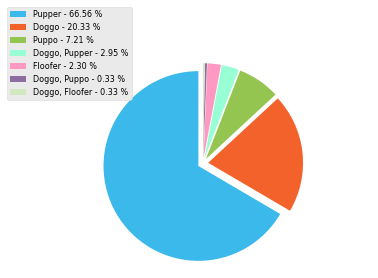

In [48]:
x = np.char.array(['Pupper', 'Doggo', 'Puppo', 'Doggo, Pupper', 'Floofer', 'Doggo, Puppo', 'Doggo, Floofer'])
y = np.array(list(df[df['dog_stage'] != 'None']['dog_stage'].value_counts())[0:7])
colors = ['#3bb9eb','#f2622a','#95c551','#98ffd5','#ff98c2','#8d6c9f','#d3e7c1']
porcent = 100.*y/y.sum()

explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.8,  explode = explode)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) 


plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.axis('equal')

plt.savefig('Most_common_dog.png', bbox_inches='tight')

Insight 1: Pupper is the most common owned dog.

### Most common rating? 

In [49]:
df_integer_ratings_14 = df[(df.rating_numerator <= 14) & (df.rating_numerator.apply(float.is_integer))]
subset_rating_counts = df_integer_ratings_14.groupby(['rating_numerator']).count()['tweet_id']

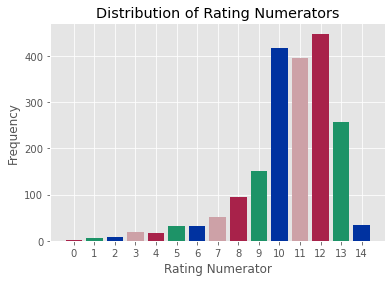

In [50]:
plt.bar(np.arange(15), subset_rating_counts, color=('#a8224a','#1d9367','#0032a0','#cda1a7'))
plt.xticks(np.arange(15))
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.title('Distribution of Rating Numerators');

plt.savefig('Most_common_rates.png', bbox_inches='tight')

Insight 2: Most tweets are given a rating between 10 to 13.

### Relationship between Likes and Retweets?

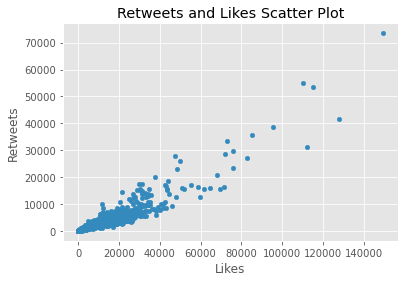

In [51]:
twitter_archive_clean.plot(x='favorites', y='retweets', kind='scatter')
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('Retweets and Likes Scatter Plot')

fig = plt.gcf()
fig.savefig('output3.png',bbox_inches='tight');

Insight 3: Retweets are positively correlated with Likes.